In [1]:
from pynvml import *
import time
import multiprocessing as mp
import torch
import pathlib
import datetime as dt
import platform
import psutil
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# 自定义的网络
from resnet_2 import *
from y_cls import *
from y_cls_1head import *

In [2]:
gpu_id = 0
"""
平台信息
gpu个数
for 模型：
    gpu显存-使用率
    内存使用率
    速度
    统计使用率 效果不好
"""
N:int = 500
# COLOR:list = list({'aliceblue':       '#F0F8FF',
#         'antiquewhite':     '#FAEBD7',
#         'aqua':             '#00FFFF',
#         'aquamarine':       '#7FFFD4',
#         'azure':            '#F0FFFF',
#         'beige':            '#F5F5DC',
#         'bisque':           '#FFE4C4',
#         'black':            '#000000',
#         'blanchedalmond':   '#FFEBCD',
#         'blue':             '#0000FF',
#         'blueviolet':       '#8A2BE2'}.values())

COLOR = ['r','g','b','y','c','m','k','w']

1 获取GPU信息

In [4]:
def get_device_info():
    nvidia_dict = {
        "state": True,
        "nvidia_version": "",
        "nvidia_count": 0,
        "gpus": []
    }
    try:
        nvmlInit()
        nvidia_dict["nvidia_version"] = nvmlSystemGetDriverVersion().decode('utf-8')
        nvidia_dict["nvidia_count"] = nvmlDeviceGetCount()
        for i in range(nvidia_dict["nvidia_count"]):
            handle = nvmlDeviceGetHandleByIndex(i)
            memory_info = nvmlDeviceGetMemoryInfo(handle)
            gpu = {
                "gpu_name": nvmlDeviceGetName(handle).decode('utf-8'),
                "total": memory_info.total,
                "free": memory_info.free,
                "used": memory_info.used,
                "temperature": f"{nvmlDeviceGetTemperature(handle, 0)}℃",
                "powerStatus": nvmlDeviceGetPowerState(handle)
            }
            nvidia_dict['gpus'].append(gpu)
    except NVMLError as _:
        nvidia_dict["state"] = False
    except Exception as _:
        nvidia_dict["state"] = False
    finally:
        try:
            nvmlShutdown()
        except:
            pass
    return nvidia_dict
def check_gpu_mem_usedRate(share_sign,share_log):
    linear = []
    points=[]
    points_lst=[]
    n=0
    while True:
        info = get_device_info()
        used = info['gpus'][0]['used']  #第0号GPU 检测
        tot = info['gpus'][0]['total']  #第0号GPU 检测
        linear.append(used/tot)
        if share_sign['recording'][1] and len(points)==0:
            points=[n]
        elif (n!=0) and (not share_sign['recording'][1]) and len(points)==1:
            points += [n]
            points_lst.append({share_sign['recording'][0]:points})
            points=[]
        n+=1
        if not share_sign['state']:
            break # 跳出监控gpu循环
    share_log['cut-points']=points_lst
    share_log['gpu-used-ratio'] = linear
    share_sign['close'] = True
    

2 获取CPU信息  没有获取infer中cpu信息，原因是在infer过程中cpu几乎用不到计算。

In [5]:

def get_host_info():
    host_dict = {
        "system_info": "",
        "memory_used_ratio": 0,
        "cpu": []
    }
    host_dict["system_info"] = platform.platform()
    host_dict["memory_used_ratio"] = psutil.virtual_memory().percent
    host_dict["cpu"]= psutil.cpu_count(logical=False)
    return host_dict

def costime(model_pth_lst,share_sign,share_log):
    data = torch.randn(1,3,224,224,device='cuda:0')
    share_log['input-data-shape'] = f'[1, 3, 224, 224]   cuda:0'
    check_info = dict()
    device = torch.device("cuda:0")
    with torch.no_grad():
        for k,m_pth in model_pth_lst.items():
            print(f'[INFO]   {k} start to check...')
            model = torch.load(m_pth).to(device=device)
            share_sign['recording'] = [k,True]
            for _ in range(4):
                model(data)
            Start_time = time.time()
            for _ in range(N):
                model(data)
            check_info[k]= f'{(time.time()-Start_time)/N:.6f} s'
            share_sign['recording'] = [k,False]
            del model
            time.sleep(10)
            print(f'[INFO]   {k} checked~')
    share_log['every-infer-cost-time'] = check_info
    share_sign['state'] = False
    while True:
        time.sleep(0.5)
        if share_sign['close']:
            break
   

3 获取权重文件列表

In [7]:
def gender_cfg(pth='weights'):
    """
    生成模型路径配置参数
    """
    tmp = dict()
    model_lst = list(pathlib.Path(pth).glob('*.pt'))
    for mpth in model_lst:
        mpth = str(mpth)
        file = mpth.split(os.path.sep)[-1]
        tmp[file[:-3]]=os.path.abspath(mpth)
    return tmp

4 各种工具

In [8]:
def dct2str(dct:dict):
    tmp = []
    for k,v in dct.items():
        tmp.append(f"{k}:  {v}\n")
    return tmp
def mkdir(p):
    if os.path.isfile(p):
        p = os.path.dirname(p)
    os.makedirs(p,exist_ok=True)
def draw_fig(share_log,figpth):
    plt.title('GPU USED RATIO')
    plt.xlabel('times')   # 统计gpu次数 不是时间秒
    plt.ylabel('used-ratio')
    
    y = share_log['gpu-used-ratio']
    x = np.linspace(0,len(y),len(y))
    plt.plot(x,y,COLOR[0],label='gpu-used-ratio',marker='.')
    for i,points in enumerate(share_log['cut-points']):
        values = list(points.values())
        plt.axvspan(xmin=values[0][0], xmax=values[0][1], facecolor=COLOR[i+1], alpha=0.3,label=list(points.keys())[0])  
    plt.legend(loc='lower right')
    plt.savefig(figpth)   
    

5 掉用主函数

[INFO]   res50_23wheel start to check...
[INFO]   res50_23wheel checked~
[INFO]   res50_4wheel start to check...
[INFO]   res50_4wheel checked~
[INFO]   yolov5n_cls_vague start to check...
[INFO]   yolov5n_cls_vague checked~
[INFO]   res50_vague start to check...
[INFO]   res50_vague checked~
[INFO]   yolov5n_cls_s_23wheel start to check...
[INFO]   yolov5n_cls_s_23wheel checked~
[INFO]   yolov5n_cls_s_4wheel start to check...
[INFO]   yolov5n_cls_s_4wheel checked~
[INFO]   start draw fig
[INFO]   check log save to /home/chenglong/code/monitor_device/log_2022_09_17-180522


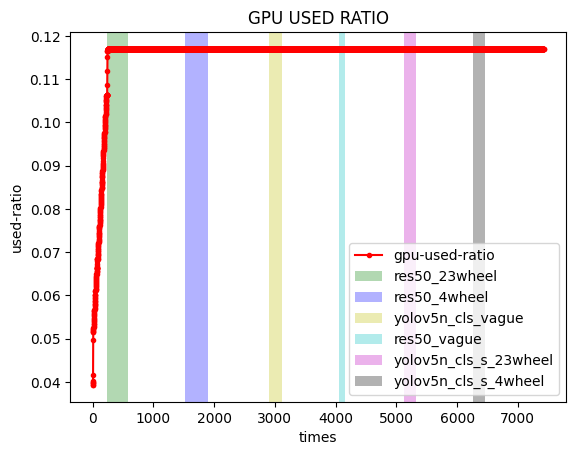

In [9]:
  
if __name__ == "__main__":
    ddp = os.path.abspath(f"log_{dt.datetime.now().strftime('%Y_%m_%d-%H%M%S')}")
    mkdir(ddp)
    
    with open(f"{ddp}/res_note.txt",'w') as f:
        f.write('*****system_info***** \n')
        host_info = get_host_info()
        host_info_lst = dct2str(host_info)
        for hif in host_info_lst:
            f.write(hif+'\n')
        f.write('*****device_info***** \n')
        device_info = get_device_info()
        device_info.pop('state')
        device_info_lst = dct2str(device_info)
        for dif in device_info_lst:
            f.write(dif+'\n')
        f.write('*****start_test***** \n')
        model_pth_lst = gender_cfg(pth='weights_bck')
        processes = []
        with mp.Manager() as MG:
            share_sign = MG.dict()
            """
            share_sign['recording'] = ['',False]  # [k,False]  or [k,True]   # 检测模型的开启结束
            share_sign['state'] = True   # 退出监控循环 
            share_sign['close'] = False   # 关闭统计gpu进程程序
            """
            share_sign['recording'] = ['',False]  # [xxx,bool]
            share_sign['state'] = True
            share_sign['close'] = False
            
            share_log = MG.dict()
            share_log['input-data-shape'] = ''
            share_log['every-infer-cost-time'] = dict()
            share_log['gpu-used-ratio'] = []  
            share_log['cut-points'] = dict()
            """key:
            ['input-data-shape']
            ['every-infer-cost-time'] - {['res18']:10.0,['res19']:11.0,['res20']:12.0}
            ['gpu-used-ratio'] - {['res18']:[],['res19']:[],['res20']:[]}  
            ['cut-points'] - {['res18']:[,],['res19']:[,],['res20']:[,]}  
            """
           
            processes.append(mp.Process(target=costime,args=(model_pth_lst,share_sign,share_log)))  # 遍历推理模型 不更新参数
            processes.append(mp.Process(target=check_gpu_mem_usedRate,args=(share_sign,share_log)))   # 一直在统计，上面给出解说命令
            for p in processes:
                p.start()
            for p in processes:
                p.join()
            
            
            f.write(f"input-data-shape    {share_log['input-data-shape']}\n")
            for k,v in share_log['every-infer-cost-time'].items():
                f.write(f"******{k}******\n")
                f.write(f"{k}.pt    {v}\n")
                            
            print("[INFO]   start draw fig")
            figpth = f"{ddp}/gpu_used_ratio.jpg"   
            draw_fig(share_log,figpth) 
    print(f"[INFO]   check log save to {ddp}")

weights_bck文件说明，放的都是权重文件
```plain text
weights_bck\
        ├── res50_4wheel.pt
        └── yolov5n_cls_s_4wheel.pt
```

requirement.txt
```plain text
pynvml
torch+cuda
pathlib
platform
psutil
numpy
matplotlib
```

改进
在统计每个模型使用gpu之间，用下面命令清除缓存。
```python3
torch.cuda.empty_cache()
```
然后判断是否干净了，再去做判断
```python3
if torch.cuda.memory_reserved('cuda:0')==0:
    return True
else:
    return False
```